In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass, field
from typing import Literal, List, Tuple, Dict
from rich import print as rprint

## 创建学生类

In [17]:
@dataclass
class Student:
    coord: tuple
    status: Literal[0, 1]
    sensitivity: float
    target_volume: float = 0.0
    prev_neighbor_avg_volume: float = 0.0
    alpha: float = 0.5
    beta: float = 0.5
    gamma: float = 0.5
    lambda_rate: float = 0.1
    theta: float = 0.2
    epsilon: float = 0.1

    @property
    def ref_volume(self) -> float:
        return self.status * self.target_volume

In [18]:
def initialize_students(row_num: int, col_num: int) -> dict:
    students_map = {}

    ALPHA = 0.5
    BETA = 0.5
    GAMMA = 0.5
    LAMBDA_RATE = 0.1
    THETA = 0.2
    EPSILON = 0.1

    for i in range(row_num):
        for j in range(col_num):
            coord = (i, j)

            target_volume = 1.0

            students_map[coord] = Student(
                coord=coord,
                status=1,
                sensitivity=1.0,
                alpha=ALPHA,
                beta=BETA,
                gamma=GAMMA,
                lambda_rate=LAMBDA_RATE,
                theta=THETA,
                epsilon=EPSILON,
                target_volume=target_volume,
                prev_neighbor_avg_volume=0.0
            )

    return students_map

students_map = initialize_students(20, 20)

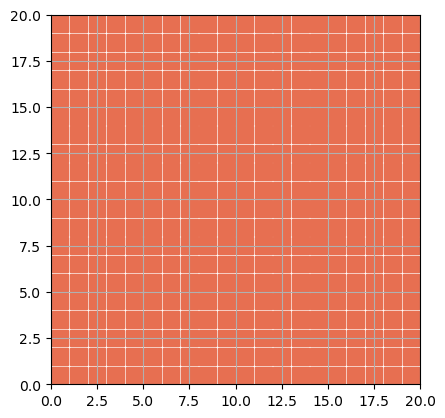

In [19]:
RECTANGLE_WIDTH = 0.9
BLANK_WIDTH = 1 - RECTANGLE_WIDTH

def plot_students(students_map):
    # 每一个学生代表一个方块，方块和方块之间有小间隙
    row_num = max(coord[0] for coord in students_map.keys()) + 1
    col_num = max(coord[1] for coord in students_map.keys()) + 1
    fig, ax = plt.subplots()
    for coord, student in students_map.items():
        color = '#00b4d8' if student.status == 0 else '#e76f51'
        rect = plt.Rectangle((coord[1] + BLANK_WIDTH / 2, row_num - coord[0] +  BLANK_WIDTH / 2 - 1), RECTANGLE_WIDTH, RECTANGLE_WIDTH, color=color)
        ax.add_patch(rect)
    ax.set_xlim(0, col_num)
    ax.set_ylim(0, row_num)
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()

plot_students(students_map)

In [22]:
P_ON = 0.3
P_OFF = 0.1

def on_off_model(student: Student, p_on: float, p_off: float) -> Literal[0, 1]:
    rand_num = np.random.rand()
    if student.status == 0:
        if rand_num < p_off:
            return 0
        else:
            return 1
    elif student.status == 1:
        if rand_num < p_on:
            return 1
        else:
            return 0
    return 1 - student.status

def get_neighbors_volume(student: Student, students_map: Dict[Tuple[int, int], Student]) -> float:
    neighbor_coords = [
        (student.coord[0] - 1, student.coord[1] - 1),
        (student.coord[0] - 1, student.coord[1]),
        (student.coord[0] - 1, student.coord[1] + 1),
        (student.coord[0], student.coord[1] - 1),
        (student.coord[0], student.coord[1] + 1),
        (student.coord[0] + 1, student.coord[1] - 1),
        (student.coord[0] + 1, student.coord[1]),
        (student.coord[0] + 1, student.coord[1] + 1),
    ]
    total_volume = 0.0
    count = 0
    for coord in neighbor_coords:
        if coord in students_map:
            neighbor = students_map[coord]
            total_volume += neighbor.ref_volume
            count += 1
    return total_volume / count if count > 0 else 0.0

def update_student_volume(student: Student, students_map: Dict[Tuple[int, int], Student], current_neighbor_avg_volume: float) -> float:

    if student.status == 0:
        return 0.0

    elif student.status == 1:

        prev_neighbor_avg_volume = student.prev_neighbor_avg_volume
        delta_e = current_neighbor_avg_volume - prev_neighbor_avg_volume
        current_volume = student.target_volume

        if current_volume <= student.epsilon:
            # 第三种情况：恢复阶段 (V_{ij}(t) ≤ ε)
            target_volume = student.target_volume
            recovery_term = student.lambda_rate * (target_volume - current_volume)
            new_volume = current_volume + recovery_term
            return new_volume

        elif delta_e < -student.theta and current_volume > student.epsilon:
            # 第二种情况：突然安静 (ΔE_{ij}(t) < -θ_{ij} 且 V_{ij}(t) > ε)
            new_volume = student.gamma * current_volume
            return new_volume

        elif delta_e >= -student.theta and current_volume > student.epsilon:
            # 第一种情况：常规阶段
            target_volume = student.target_volume
            imitation_term = student.alpha * (target_volume - current_volume)
            self_drive_term = student.beta * (target_volume - current_volume)
            new_volume = current_volume + imitation_term + self_drive_term
            return new_volume

    return student.original_volume

def update_student_state(student, students_map, current_t, time_steps):
    new_status = on_off_model(student, P_ON, P_OFF)
    current_neighbor_avg_volume = get_neighbors_volume(student, students_map)

    temp_student = student
    temp_student.status = new_status
    new_volume = update_student_volume(temp_student, students_map, current_neighbor_avg_volume)

    temp_student.status = student.status

    return {
        'new_status': new_status,
        'new_original_volume': new_volume,
        'new_prev_neighbor_avg_volume': current_neighbor_avg_volume 
    }

In [23]:
import pandas as pd

all_students_trajectory = []
time_steps = range(100)

for current_t in time_steps:
    updates = {}

    for coord, student in students_map.items():
        update_info = update_student_state(student, students_map, current_t, time_steps)
        updates[coord] = update_info

    for coord, info in updates.items():
        student = students_map[coord]
        student.status = info['new_status']
        student.original_volume = info['new_original_volume']
        student.prev_neighbor_avg_volume = info['new_prev_neighbor_avg_volume']

    current_step_data = []
    for student in students_map.values():
        snapshot = {
            "time_step": current_t,
            "coord": student.coord,
            "status": student.status,
            "original_volume": student.original_volume,
            "ref_volume": student.ref_volume
        }
        current_step_data.append(snapshot)

    all_students_trajectory.extend(current_step_data)

df_all_data = pd.DataFrame(all_students_trajectory)

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# 之前的配置常量
RECTANGLE_WIDTH = 0.9
BLANK_WIDTH = 1 - RECTANGLE_WIDTH

def create_simulation_gif(df_data, filename='simulation.gif'):

    max_row = df_data['coord'].apply(lambda x: x[0]).max()
    max_col = df_data['coord'].apply(lambda x: x[1]).max()
    row_num = max_row + 1
    col_num = max_col + 1

    time_steps = df_data['time_step'].unique()

    fig, ax = plt.subplots(figsize=(6, 6))
    
    def update(frame_time):
        ax.clear()

        current_df = df_data[df_data['time_step'] == frame_time]

        ax.set_xlim(0, col_num)
        ax.set_ylim(0, row_num)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Time Step: {frame_time}")

        for _, row in current_df.iterrows():
            coord = row['coord']
            status = row['status']

            color = '#e76f51' if status == 1 else '#00b4d8'

            x_bl = coord[1] + BLANK_WIDTH / 2
            y_bl = (row_num - 1 - coord[0]) + BLANK_WIDTH / 2

            rect = plt.Rectangle(
                (x_bl, y_bl), 
                RECTANGLE_WIDTH, 
                RECTANGLE_WIDTH, 
                color=color
            )
            ax.add_patch(rect)

    ani = animation.FuncAnimation(fig, update, frames=time_steps, interval=200)

    print(f"正在生成 {filename}，请稍候...")

    ani.save(filename, writer='pillow', fps=10)
    print(f"生成完成！已保存为 {filename}")
    plt.close()

create_simulation_gif(df_all_data, filename='classroom_simulation.gif')

正在生成 classroom_simulation.gif，请稍候...
生成完成！已保存为 classroom_simulation.gif
